In [1]:
from utils import *

from load_data import corpus_train, corpus_dev, corpus_test
from pcfg import grammar_counts, set_terminal_symbols, set_all_symbols
from oov import tagger

def apply_TERM_rule(grammar, max_idx_new_symbol):
    #apply TERM RULE (eliminate rules with nonsolitary terminals)
    
    already_applied_TERM = {} #key : symbol, value : corresponding pre-terminal added
    
    grammar0 = deepcopy(grammar)
    
    for (root_tag, rules) in grammar0.items():
        
        for (list_tags, counts) in rules.items():
            
            if len(list_tags)>1:
                                
                new_list_symbols = [] #right hand term of new rule deriving root_tag
                require_TERM = False #is there a non-solitary terminal symbol
                
                for tag in list_tags:
                    if tag in set_terminal_symbols:
                        require_TERM = True #there is a non solitary terminal symbol
                        if not(tag in already_applied_TERM.keys()): 
                            symbol = "NEW_" + str(max_idx_new_symbol)
                            max_idx_new_symbol += 1
                            grammar[symbol] = {tuple([tag]) : counts}
                            already_applied_TERM[tag] = symbol
                        else:
                            symbol=already_applied_TERM[tag]
                            grammar[symbol][tuple([tag])] += counts
                        #print(symbol,tuple([tag]))
                        new_list_symbols.append(symbol)
                    else:
                        new_list_symbols.append(tag)
                
                if require_TERM:
                                        
                    del grammar[root_tag][list_tags]
                    grammar[root_tag][tuple(new_list_symbols)] = counts
                    #print(root_tag,tuple(new_list_symbols))
                    #print(root_tag,list_tags)
                                        
    return max_idx_new_symbol

def apply_BIN_rule(grammar, max_idx_new_symbol):
    #apply BIN RULE (eliminate right-hand sides with more than 2 nonterminals)
    
    grammar0 = deepcopy(grammar)
    
    for (root_tag, rules) in grammar0.items():
        #root_tag is the left hand symbol of the grammar rule
        #rules are the PCFC rules for derivation of root_tag

        for (list_tags, counts) in rules.items():
            #print(list_tags)
            nb_consecutive_tags = len(list_tags)
            
            if nb_consecutive_tags>2:                
                del grammar[root_tag][list_tags]
                
                symbol = "NEW_" + str(max_idx_new_symbol)
                max_idx_new_symbol += 1
                grammar[root_tag][(list_tags[0],symbol)] = counts
                #print(root_tag,list_tags[0],symbol)
                
                for k in range(1,nb_consecutive_tags-2):
                    new_symbol = "NEW_" + str(max_idx_new_symbol)
                    max_idx_new_symbol += 1
                    grammar[symbol] = {(list_tags[k],new_symbol): counts}
                    #print(symbol,list_tags[k],new_symbol)
                    symbol = new_symbol
                #print(symbol,list_tags[-2],list_tags[-1])
                
                grammar[symbol] = {(list_tags[-2],list_tags[-1]): counts}
                
    return max_idx_new_symbol

def apply_UNIT_rule(grammar, max_idx_new_symbol):
    
    grammar0 = deepcopy(grammar)
    
    #apply UNIT rule (eliminate unit rules)
    
    for (root_tag, rules) in grammar0.items():
        #root_tag is the left hand symbol of the grammar rule
        #rules are the PCFC rules for derivation of root_tag

        for (list_tags, counts) in rules.items():
            
            if len(list_tags)==1:
                child_tag = list_tags[0]
                
                if (not(root_tag in set_terminal_symbols)) and (not(child_tag in set_terminal_symbols)):
                    
                    #print(root_tag, child_tag)
                    
                    freq = counts/(np.sum(list(grammar[root_tag].values())))
                    del grammar[root_tag][list_tags]
                    
                    for (list_tags, counts2) in grammar[child_tag].items():
                        
                        grammar[root_tag][list_tags] = counts2 * freq
                        #print(child_tag,list_tags,counts2)
                        #print(root_tag,list_tags,counts2 * freq)
                        
    return max_idx_new_symbol


def binarize_PCFG(grammar, lexicon):
    #grammar with counts(not probas) !!!
    #cf. https://en.wikipedia.org/wiki/Chomsky_normal_form
    
    binary_grammar = deepcopy(grammar)
    
    #convert into Chomsky_normal_form
        
    #no need for START RULE (tag 'SENT' is already always at the left)
    
    max_idx_new_symbol = 0
    
    #apply TERM RULE (eliminate rules with nonsolitary terminals)
    max_idx_new_symbol = apply_TERM_rule(binary_grammar, max_idx_new_symbol)
        
    #apply BIN RULE (eliminate right-hand sides with more than 2 nonterminals)
    max_idx_new_symbol = apply_BIN_rule(binary_grammar, max_idx_new_symbol)
    
    #apply UNIT rule (eliminate unit rules)
    max_idx_new_symbol = apply_UNIT_rule(binary_grammar, max_idx_new_symbol)

    #no need for DEL rules (no such cases)
    
    return binary_grammar, max_idx_new_symbol

building pcfg from corpus train

list of all symbols
['ADJ' 'ADJWH' 'ADV' 'ADVWH' 'AP' 'AdP' 'CC' 'CLO' 'CLR' 'CLS' 'COORD'
 'CS' 'DET' 'DETWH' 'ET' 'I' 'NC' 'NP' 'NPP' 'P' 'P+D' 'P+PRO' 'PONCT'
 'PP' 'PREF' 'PRO' 'PROREL' 'PROWH' 'SENT' 'Sint' 'Srel' 'Ssub' 'V' 'VIMP'
 'VINF' 'VN' 'VPP' 'VPR' 'VPinf' 'VPpart' 'VS']

list of terminal symbols
['ADJ' 'ADJWH' 'ADV' 'ADVWH' 'CC' 'CLO' 'CLR' 'CLS' 'CS' 'DET' 'DETWH'
 'ET' 'I' 'NC' 'NPP' 'P' 'P+D' 'P+PRO' 'PONCT' 'PREF' 'PRO' 'PROREL'
 'PROWH' 'V' 'VIMP' 'VINF' 'VPP' 'VPR' 'VS']

##################################

building oov tagger

8958  words in lexicon
7427  words in lexicon having an embedding
(7427, 64)

##################################



In [18]:
EPS = math.pow(10,-10)

def compute_CYK_tables(sentence):
    #(cf. https://en.wikipedia.org/wiki/CYK_algorithm)
    #finding most likely symbol deriving each substring, for increasing length of substring (from 1 to length of the sentence)
    #and storing each time the position of the cut and the grammar rule enabling to reach such most likely derivation
    
    nb_words = len(sentence)
   
    max_proba_derivation = np.zeros((nb_words,nb_words,nb_all_symbols))
    #max_proba_derivation[s,l,a] is the maximum probability of
    #a parsing where symbol a derives substring x_s...x_(s+l)
    
    split_reaching_max = np.zeros((nb_words,nb_words,nb_all_symbols,3))
    #split_reaching_max[s,l,a,0] stores index cut
    #split_reaching_max[s,l,a,1] stores symbol b
    #split_reaching_max[s,l,a,2] stores symbol c
    
    #(i) b derives x_s...x_(s+cut), c derives x_(s+cut)...x_(s+l)
    #and a rewrites bc (a->bc in the grammar)
    
    #(ii) the splitting <cut,b,c> defined by (i) is the one enabling
    #to reach the maximum probability for a to derives  x_s...x_(s+l)
    #(ie enabling to reach max_proba_derivation[s,l,a])

    #probabilities of tags for unary strings (words)
    for (position_word,word) in enumerate(sentence):
        tags = tagger(word) #tagger[word] #
        for (tag, proba) in tags.items():
            id_tag = symbol_to_id[tag]
            max_proba_derivation[position_word,0,id_tag] = proba
            
    #print(max_proba_derivation[:,0,:])
    
    for l in range(1, nb_words):
        #we will consider symbols deriving strings of length l+1...
        
        for s in range(nb_words-l):
            #... and starting at index s of the sentence
            
            for cut in range(0,l): 
                #... and such that the symbol can rewrite as two symbols AB
                #with A deriving substring until index cut included, and B deriving substring from index cut+1
                
                for (root_tag, rules) in binary_grammar.items():
                    #root_tag is the left hand symbol of the grammar rule
                    #rules are the PCFC rules for derivation of root_tag
                    
                    idx_root_tag = symbol_to_id[root_tag]
                    
                    for (split, proba) in rules.items():
                        #root_tag can rewrite split[0]split[1] with probability proba
                        
                        if len(split)==2: #disregard rules A->B, consider only A->BC
                            
                            idx_left_tag = symbol_to_id[split[0]] #idx of left split tag
                            idx_right_tag = symbol_to_id[split[1]] #idx of right split tag
                                                        
                            proba_decomposition = proba
                            proba_decomposition *= max_proba_derivation[s,cut,idx_left_tag]
                            proba_decomposition *= max_proba_derivation[s+cut+1,l-cut-1,idx_right_tag]
                            
                            if proba_decomposition > max_proba_derivation[s,l,idx_root_tag]:
                                #therefore, we found a new decomposition <cut,split[0],split[1]>
                                #reaching a highest probability for root_tag to derive substring x_s...x_(s+l)

                                max_proba_derivation[s,l,idx_root_tag] = proba_decomposition
                                split_reaching_max[s,l,idx_root_tag,0] = cut
                                split_reaching_max[s,l,idx_root_tag,1] = idx_left_tag
                                split_reaching_max[s,l,idx_root_tag,2] = idx_right_tag
    
        #print(max_proba_derivation[:,l,:])
                            
    return max_proba_derivation, split_reaching_max.astype(int)

#Rq for report : max_proba_derivation is non zero if there exists a triplet such that both are non zero and ...


def parse_substring(s,l,idx_root_tag, sentence, max_proba_derivation, split_reaching_max):
    #parse substring beginning at index s of sentence, of length l+1, and tagged as idx_root_tag
    
    nb_words = max_proba_derivation.shape[0]
        
    if l==0: #void string        
        return sentence[s]
    
    else: #split enabling to reach max_proba_derivation[s,l,idx_root_tag]
        cut = split_reaching_max[s,l,idx_root_tag,0]
        idx_left_tag = split_reaching_max[s,l,idx_root_tag,1]
        idx_right_tag = split_reaching_max[s,l,idx_root_tag,2]
        
        left_tag = set_all_symbols[idx_left_tag]
        right_tag = set_all_symbols[idx_right_tag]
        
        #print(l,cut,l-cut)
                    
        return [[left_tag,parse_substring(s, cut, idx_left_tag, sentence, max_proba_derivation, split_reaching_max)],
                [right_tag,parse_substring(s+cut+1, l-cut-1, idx_right_tag, sentence, max_proba_derivation, split_reaching_max)]]
        
def remove_artificial_symbols(parsing_dico):
    if type(parsing_dico)==str:
        return parsing_dico
    else:
        new_parsing_dico = []
        for el in parsing_dico:
            root_tag = el[0]
            rules = el[1]
            if symbol_to_id[root_tag]>=nb_tags: #artificial symbol
                dico = remove_artificial_symbols(rules)
                for el2 in dico:
                    new_parsing_dico.append([el2[0], el[1]])
            else:
                new_parsing_dico.append([root_tag, rules])
        return new_parsing_dico
            
def parse(sentence):

    sentence = sentence.split()

    nb_words = len(sentence)
    
    max_proba_derivation, split_reaching_max = compute_CYK_tables(sentence)    
        
    #idx_root_tag = np.argmax(max_proba_derivation[0,nb_words,:])
    idx_root_tag = symbol_to_id["SENT"]
    #rq ca devrait etre toujours S_0 à ce point !!!
    
    parsing_dico = parse_substring(0,nb_words-1,idx_root_tag, sentence, max_proba_derivation, split_reaching_max)
    
    print(parsing_dico)
    
    res = remove_artificial_symbols(parsing_dico)
    
    return res

def reformat_parsing(parsing):
    #converting parsing stored as a dictionnary into the required format (with nested brackets)
    
    if type(parsing)==str:
        return parsing

    else:
        string=""
        for el in parsing:
            root_tag = el[0]
            parsing_substring = el[1]
            string = string + "(" + root_tag + " " + reformat_parsing(parsing_substring) + ")" + " "
        string = string[:-1]
        return string    

def parser(sentence):
    return "( (SENT " + reformat_parsing(parse(sentence)) + "))"    

In [19]:
######################################################################################################

if False: #test
    binary_grammar = {"SENT":{("GRP1","GRP2"):1},"GRP1":{("ADV","VERB"):1},"GRP2":{("ART","NOM"):1}}
    tagger = {"Il":{"ADV":1},"demande":{"VERB":1},"le":{"ART":1},"renvoi":{"NOM":1}}
    set_all_symbols = ["SENT","GRP1","GRP2","ADV","VERB","ART","NOM","PUNCT"]  #redefining variable
    nb_tags = 8 
    nb_all_symbols = len(set_all_symbols) #redefining variable
    symbol_to_id = {tag:i for (i,tag) in enumerate(set_all_symbols)}


else:
    print(grammar_counts.keys())
    binary_grammar_counts, max_idx_new_symbol = binarize_PCFG_grammar(grammar_counts)
    binary_grammar = normalize_counts(binary_grammar_counts)
    
    #print(binary_grammar.keys())
    #print(binary_grammar['SENT'])
    #print(np.sum(list(binary_grammar['SENT'].values())))
    
    for (root,rules) in binary_grammar.items():
        for (right, proba) in rules.items():
            print(root, right, proba)
        if np.sum(list(rules.values()))!=1:
            print("Aie")

    new_symbols = ["NEW_"+str(s) for s in range(max_idx_new_symbol)]
    set_tags = list(set_all_symbols)
    set_all_symbols = set_tags + new_symbols  #redefining variable
    nb_all_symbols = len(set_all_symbols) #redefining variable

    symbol_to_id = {symbol:i for (i,symbol) in enumerate(set_all_symbols)}
    nb_tags = len(set_tags) #if the id of a symbol is above nb_tags, its an artificial symbol added for normalization (not a gramm tag)

######################################################################################################

dict_keys(['SENT', 'Ssub', 'COORD', 'PP', 'VPpart', 'Sint', 'VPinf', 'AP', 'Srel', 'NP', 'AdP', 'VN'])
NEW_4072 ('NEW_9', 'NEW_4073') 1.0
NEW_1047 ('NEW_0', 'COORD') 1.0
NEW_5737 ('NEW_0', 'NEW_5738') 1.0
NEW_1120 ('COORD', 'NEW_1121') 1.0
NEW_5529 ('PP', 'NEW_5530') 1.0
NEW_7994 ('NEW_0', 'NEW_7995') 1.0
NEW_4774 ('NEW_0', 'NEW_4775') 1.0
NEW_2901 ('NEW_13', 'NEW_2902') 1.0
NEW_6285 ('NEW_0', 'NEW_6286') 1.0
NEW_4395 ('NEW_0', 'NEW_4396') 1.0
NEW_3088 ('NP', 'NEW_3089') 1.0
NEW_6677 ('PP', 'NEW_6678') 1.0
NEW_5629 ('NEW_0', 'NEW_5630') 1.0
NEW_7490 ('NP', 'NEW_7491') 1.0
NEW_3785 ('NEW_0', 'NP') 1.0
NEW_6818 ('VN', 'NEW_6819') 1.0
NEW_6803 ('NEW_1', 'NEW_6804') 1.0
NEW_2183 ('PP', 'NEW_2184') 1.0
NEW_8387 ('NEW_0', 'Ssub') 1.0
NEW_2567 ('NEW_13', 'NEW_2568') 1.0
NEW_19 ('DETWH',) 1.0
NEW_7662 ('VN', 'NEW_7663') 1.0
NEW_7487 ('NEW_0', 'NEW_7488') 1.0
NEW_1166 ('VPinf', 'COORD') 1.0
NEW_3708 ('COORD', 'NEW_3709') 1.0
NEW_7139 ('NEW_0', 'NEW_7140') 1.0
NEW_634 ('NP', 'NEW_635') 1.0
NEW_5

NEW_7235 ('NEW_0', 'NEW_7236') 1.0
NEW_1698 ('VN', 'NEW_1699') 1.0
NEW_7857 ('NP', 'NEW_0') 1.0
NEW_4698 ('NEW_0', 'NEW_4699') 1.0
NEW_6147 ('NP', 'NEW_6148') 1.0
NEW_7591 ('VPinf', 'NEW_0') 1.0
NEW_3819 ('VPpart', 'NEW_3820') 1.0
NEW_2749 ('NEW_0', 'NEW_2750') 1.0
NEW_280 ('NP', 'NEW_281') 1.0
NEW_7824 ('NP', 'NEW_7825') 1.0
NEW_6450 ('NEW_0', 'NEW_6451') 1.0
NEW_6306 ('VN', 'NEW_6307') 1.0
NEW_6638 ('PP', 'NEW_6639') 1.0
NEW_2924 ('NEW_12', 'PP') 1.0
NEW_4380 ('NEW_13', 'NEW_4381') 1.0
NEW_5958 ('NEW_0', 'NEW_5959') 1.0
NEW_5255 ('PP', 'NEW_5256') 1.0
NEW_1913 ('NEW_20', 'NEW_20') 1.0
NEW_2920 ('AP', 'NEW_0') 1.0
NEW_8197 ('NP', 'NEW_8198') 1.0
NEW_2698 ('AP', 'NEW_2699') 1.0
NEW_5125 ('VPinf', 'NEW_5126') 1.0
NEW_3017 ('NEW_9', 'NEW_3018') 1.0
NEW_6470 ('NP', 'NEW_6471') 1.0
NEW_2964 ('NEW_8', 'NEW_2965') 1.0
NEW_5297 ('NP', 'NEW_5298') 1.0
NEW_3485 ('NEW_9', 'NEW_3486') 1.0
NEW_5990 ('NP', 'NEW_5991') 1.0
NEW_5783 ('PP', 'NEW_5784') 1.0
NEW_3831 ('NEW_13', 'NEW_3832') 1.0
NEW_7910 

NEW_6939 ('VN', 'NEW_6940') 1.0
NEW_7780 ('NEW_0', 'NEW_7781') 1.0
NEW_800 ('NEW_1', 'VPinf') 1.0
NEW_3178 ('NEW_13', 'NEW_3179') 1.0
NEW_2621 ('NEW_0', 'NEW_2622') 1.0
NEW_8033 ('NEW_0', 'NEW_8034') 1.0
NEW_5100 ('NEW_0', 'NEW_5101') 1.0
NEW_93 ('NEW_1', 'PP') 1.0
NEW_2549 ('NEW_0', 'PP') 1.0
NEW_6139 ('NEW_0', 'NEW_6140') 1.0
NEW_5083 ('VN', 'NEW_5084') 1.0
NEW_3962 ('NEW_9', 'NEW_3963') 1.0
NEW_1729 ('Ssub', 'NEW_0') 1.0
NEW_3725 ('Sint', 'NEW_0') 1.0
NEW_2624 ('PP', 'NEW_2625') 1.0
NEW_5800 ('VN', 'NEW_5801') 1.0
NEW_6486 ('NP', 'NEW_6487') 1.0
NEW_4940 ('VN', 'NEW_4941') 1.0
NEW_5322 ('PP', 'NEW_5323') 1.0
NEW_297 ('NEW_0', 'NP') 1.0
NEW_2706 ('NEW_0', 'VPpart') 1.0
NEW_3440 ('NEW_0', 'NEW_3441') 1.0
NEW_2061 ('VPpart', 'NEW_2062') 1.0
NEW_484 ('NP', 'NEW_485') 1.0
NEW_4674 ('VN', 'NEW_4675') 1.0
NEW_2843 ('COORD', 'NEW_2844') 1.0
NEW_4191 ('NEW_13', 'NEW_4192') 1.0
NEW_1992 ('NEW_13', 'NEW_1993') 1.0
NEW_5296 ('NEW_0', 'NEW_5297') 1.0
NEW_1523 ('PP', 'NEW_1524') 1.0
NEW_974 ('NEW

NEW_5702 ('NEW_1', 'NEW_5703') 1.0
NEW_538 ('VPinf', 'NEW_0') 1.0
NEW_732 ('NEW_0', 'NEW_733') 1.0
NEW_7509 ('NEW_0', 'NEW_7510') 1.0
NEW_3362 ('NEW_13', 'NEW_3363') 1.0
NEW_6258 ('PP', 'NEW_0') 1.0
NEW_1093 ('COORD', 'COORD') 1.0
NEW_222 ('NEW_0', 'NEW_223') 1.0
NEW_2167 ('NEW_13', 'PP') 1.0
NEW_8398 ('COORD', 'COORD') 1.0
NEW_6427 ('NEW_0', 'NEW_6428') 1.0
NEW_133 ('NP', 'NEW_134') 1.0
NEW_7580 ('NEW_0', 'NEW_7581') 1.0
NEW_7913 ('NEW_1', 'NEW_7914') 1.0
NEW_4359 ('NEW_0', 'NEW_13') 1.0
NEW_3208 ('COORD', 'COORD') 1.0
NEW_2345 ('PP', 'PP') 1.0
NEW_4378 ('PP', 'NEW_4379') 1.0
NEW_5259 ('PP', 'NEW_5260') 1.0
NEW_8104 ('NP', 'NEW_0') 1.0
NEW_3807 ('NP', 'NEW_0') 1.0
NEW_4440 ('NEW_13', 'NEW_4441') 1.0
NEW_4131 ('COORD', 'COORD') 1.0
NEW_6383 ('VN', 'NEW_6384') 1.0
NEW_6667 ('PP', 'NEW_6668') 1.0
NEW_3501 ('NEW_4', 'NEW_4') 1.0
NEW_5280 ('COORD', 'NEW_0') 1.0
NEW_3149 ('PP', 'NEW_3150') 1.0
NEW_836 ('Sint', 'NEW_837') 1.0
NEW_5011 ('NP', 'NEW_5012') 1.0
NEW_4348 ('NEW_4', 'NEW_4349') 1.0

NEW_413 ('VN', 'NEW_414') 1.0
NEW_3268 ('NEW_0', 'NEW_3269') 1.0
NEW_5871 ('NP', 'NEW_5872') 1.0
NEW_1288 ('PP', 'Ssub') 1.0
NEW_8812 ('NEW_15', 'NEW_0') 1.0
NEW_4751 ('COORD', 'NEW_4752') 1.0
NEW_2015 ('NEW_4', 'NEW_2016') 1.0
NEW_996 ('NEW_1', 'NEW_997') 1.0
NEW_4764 ('NEW_0', 'NEW_4765') 1.0
NEW_8207 ('NEW_0', 'NEW_8208') 1.0
NEW_4519 ('VN', 'NEW_4520') 1.0
NEW_661 ('VN', 'NEW_662') 1.0
NEW_7971 ('NP', 'NEW_7972') 1.0
NEW_6923 ('NEW_0', 'NEW_6924') 1.0
NEW_2720 ('Sint', 'NEW_0') 1.0
NEW_2103 ('PP', 'NEW_2104') 1.0
NEW_4221 ('NP', 'NEW_0') 1.0
NEW_678 ('VN', 'NEW_679') 1.0
NEW_3692 ('NEW_11', 'NEW_3693') 1.0
NEW_2217 ('AP', 'NEW_2218') 1.0
NEW_2207 ('COORD', 'AP') 1.0
NEW_3203 ('NEW_0', 'NEW_3204') 1.0
NEW_2411 ('NEW_11', 'NEW_12') 1.0
NEW_3955 ('NEW_4', 'NEW_3956') 1.0
NEW_8005 ('PP', 'NEW_0') 1.0
NEW_8717 ('VN', 'NEW_8718') 1.0
NEW_270 ('PP', 'NEW_271') 1.0
NEW_3275 ('PP', 'NEW_3276') 1.0
NEW_6249 ('VN', 'NEW_6250') 1.0
NEW_523 ('VPinf', 'NEW_524') 1.0
NEW_5115 ('NEW_1', 'NEW_5116'

NEW_506 ('NEW_0', 'Ssub') 1.0
NEW_7441 ('VN', 'NEW_7442') 1.0
NEW_6631 ('NEW_1', 'NEW_6632') 1.0
NEW_8465 ('NEW_0', 'PP') 1.0
NEW_3060 ('COORD', 'NEW_3061') 1.0
NEW_819 ('NP', 'NEW_820') 1.0
NEW_1308 ('AP', 'NP') 1.0
NEW_5638 ('NP', 'NEW_5639') 1.0
NEW_6295 ('NEW_0', 'NEW_6296') 1.0
NEW_3175 ('Srel', 'VPpart') 1.0
NEW_8654 ('PP', 'NEW_8655') 1.0
NEW_8020 ('VN', 'NEW_8021') 1.0
NEW_1392 ('NEW_0', 'NEW_1393') 1.0
NEW_5492 ('VN', 'NEW_5493') 1.0
NEW_1157 ('NP', 'NEW_1158') 1.0
NEW_2334 ('COORD', 'COORD') 1.0
NEW_2399 ('NEW_4', 'AP') 1.0
NEW_3634 ('PP', 'VPpart') 1.0
NEW_5539 ('NEW_1', 'NEW_0') 1.0
NEW_4754 ('NEW_0', 'NEW_0') 1.0
NEW_8928 ('NEW_1', 'NEW_15') 1.0
NEW_8751 ('NEW_0', 'NEW_8752') 1.0
NEW_3734 ('AP', 'VPpart') 1.0
NEW_4849 ('VN', 'NEW_4850') 1.0
NEW_4149 ('NEW_20', 'NEW_4150') 1.0
NEW_6630 ('VN', 'NEW_6631') 1.0
NEW_8506 ('NEW_0', 'PP') 1.0
NEW_4369 ('NEW_0', 'NEW_4370') 1.0
NEW_4120 ('NEW_13', 'NEW_4121') 1.0
NEW_623 ('NEW_1', 'NEW_0') 1.0
NEW_715 ('PP', 'NEW_716') 1.0
NEW_101

VPpart ('NEW_22', 'NEW_8905') 1.3276333607710892e-05
VPpart ('NEW_23', 'NEW_8972') 0.0002588885053503624
VPpart ('NEW_7', 'NEW_8795') 0.0010388731048033774
VPpart ('V',) 0.007202410982183159
VPpart ('NEW_7', 'COORD') 0.005194365524016887
VPpart ('NEW_22', 'NEW_8861') 6.638166803855446e-05
VPpart ('NEW_26', 'NEW_7') 0.00014603966968481982
VPpart ('NEW_7', 'PP') 0.3085453121266031
VPpart ('NEW_1', 'NEW_8919') 0.00026552667215421784
VPpart ('NP', 'NEW_8690') 0.0010388731048033774
VPpart ('NEW_22', 'NEW_8871') 6.638166803855446e-06
VPpart ('NEW_7', 'NEW_8800') 0.0010388731048033774
VPpart ('NEW_7', 'NEW_8675') 0.0010388731048033774
VPpart ('NEW_16', 'NEW_22') 0.0003053556729773505
VPpart ('NEW_23', 'NEW_8903') 6.638166803855446e-06
VPpart ('NP', 'NEW_8720') 0.0010388731048033774
VPpart ('NEW_1', 'NEW_8847') 6.638166803855446e-06
VPpart ('NEW_22', 'NEW_8916') 3.319083401927723e-05
VPpart ('NEW_23', 'NEW_8883') 6.638166803855446e-06
VPpart ('VN', 'NEW_8796') 0.0010388731048033774
VPpart ('NE

NEW_2507 ('NEW_0', 'NEW_2508') 1.0
NEW_2351 ('NEW_13', 'PP') 1.0
NEW_6365 ('PP', 'NEW_6366') 1.0
NEW_275 ('Sint', 'NEW_276') 1.0
NEW_5748 ('NEW_0', 'NEW_5749') 1.0
NEW_7335 ('NEW_0', 'NEW_0') 1.0
NEW_7010 ('NP', 'NEW_7011') 1.0
NEW_4685 ('NP', 'NEW_4686') 1.0
NEW_5486 ('PP', 'NEW_5487') 1.0
NEW_4056 ('NEW_0', 'NEW_4057') 1.0
NEW_8791 ('NP', 'NEW_8792') 1.0
NEW_2119 ('NEW_1', 'NEW_0') 1.0
NEW_6792 ('NEW_0', 'NEW_6793') 1.0
NEW_8775 ('NEW_1', 'PP') 1.0
NEW_2853 ('AP', 'NEW_2854') 1.0
NEW_4891 ('NP', 'NEW_4892') 1.0
NEW_8674 ('NEW_0', 'Sint') 1.0
NEW_5518 ('PP', 'NEW_0') 1.0
NEW_2717 ('NEW_0', 'NEW_2718') 1.0
NEW_360 ('VN', 'NEW_361') 1.0
NEW_6257 ('PP', 'NEW_6258') 1.0
NEW_8858 ('NEW_1', 'NEW_7') 1.0
NEW_4869 ('NP', 'NEW_0') 1.0
NEW_3265 ('AP', 'NEW_3266') 1.0
NEW_6745 ('NEW_0', 'NEW_6746') 1.0
NEW_6072 ('Ssub', 'NEW_0') 1.0
NEW_5363 ('PP', 'NEW_5364') 1.0
NEW_7055 ('VN', 'NEW_7056') 1.0
NEW_2944 ('NEW_0', 'NEW_2945') 1.0
NEW_511 ('NP', 'Srel') 1.0
NEW_4123 ('NEW_13', 'PP') 1.0
NEW_7498 

PP ('NEW_0', 'NEW_2996') 8.13047703722665e-08
PP ('NEW_20', 'NEW_1913') 1.62609540744533e-07
PP ('NEW_13', 'NEW_4027') 8.13047703722665e-08
PP ('NEW_13', 'NEW_3847') 1.62609540744533e-07
PP ('NEW_8', 'NEW_3904') 8.13047703722665e-08
PP ('NEW_1', 'NEW_1875') 1.634193424836099e-08
PP ('NEW_9', 'NEW_3390') 8.13047703722665e-08
PP ('NEW_9', 'NEW_2873') 2.439143111167995e-07
PP ('NEW_9', 'NEW_3343') 8.13047703722665e-08
PP ('NEW_9', 'NEW_2543') 8.13047703722665e-08
PP ('NEW_9', 'NEW_4361') 2.0000973511577556e-05
PP ('NEW_12', 'NP') 8.13047703722665e-08
PP ('NEW_9', 'NEW_4124') 8.13047703722665e-08
PP ('NEW_9', 'NEW_3773') 8.13047703722665e-08
PP ('NEW_13', 'NEW_2453') 8.13047703722665e-08
PP ('NEW_8', 'NEW_2350') 5.691333926058655e-07
PP ('NEW_13', 'NEW_4203') 8.13047703722665e-08
PP ('NEW_9', 'NEW_3082') 1.62609540744533e-07
PP ('NEW_9', 'NEW_4400') 2.439143111167995e-07
PP ('NEW_8', 'NEW_3973') 1.62609540744533e-07
PP ('NEW_9', 'NEW_4233') 8.13047703722665e-08
PP ('AdP', 'NEW_3696') 8.130

SENT ('NEW_13', 'NEW_4071') 3.1372564230930937e-10
SENT ('NP', 'NEW_5480') 0.00046093965906898195
SENT ('NEW_0', 'NEW_4066') 3.1372564230930937e-10
SENT ('NEW_9', 'NEW_2845') 3.1372564230930937e-10
SENT ('NEW_13', 'NEW_1956') 3.1372564230930937e-10
SENT ('NP', 'NEW_6925') 0.00046093965906898195
SENT ('NEW_0', 'NEW_2681') 6.274512846186187e-10
SENT ('NEW_4', 'NEW_2476') 3.1372564230930937e-10
SENT ('NEW_13', 'NEW_3949') 3.1372564230930937e-10
SENT ('NEW_13', 'NEW_1892') 9.411769269279282e-10
SENT ('VN', 'NEW_4458') 0.00046093965906898195
SENT ('VPpart', 'NEW_8179') 0.00046093965906898195
SENT ('NEW_9', 'NEW_2989') 3.1372564230930937e-10
SENT ('NEW_13', 'NEW_3430') 3.1372564230930937e-10
SENT ('PP', 'NEW_5944') 0.00046093965906898195
SENT ('VN', 'NEW_5943') 0.020281344999035205
SENT ('NP', 'NEW_7982') 0.009218793181379638
SENT ('NEW_9', 'NEW_3351') 3.1372564230930937e-10
SENT ('NP', 'NEW_4674') 0.0009218793181379639
SENT ('NEW_9', 'NEW_2786') 3.1372564230930937e-10
SENT ('NEW_9', 'NEW_43

SENT ('NEW_0', 'NEW_2488') 9.411769269279282e-10
SENT ('NEW_11', 'NEW_3732') 3.1372564230930937e-10
SENT ('NP', 'NEW_6035') 0.00046093965906898195
SENT ('NP', 'NEW_6342') 0.00046093965906898195
SENT ('NEW_8', 'NEW_1515') 4.682648682116425e-06
SENT ('NEW_9', 'NEW_2435') 3.1372564230930937e-10
SENT ('NEW_13', 'NEW_3388') 3.1372564230930937e-10
SENT ('Ssub', 'NEW_6970') 0.00046093965906898195
SENT ('PP', 'NEW_7504') 0.0009218793181379639
SENT ('NEW_8', 'NEW_3557') 3.1372564230930937e-10
SENT ('NEW_9', 'NEW_2499') 3.1372564230930937e-10
SENT ('AdP', 'NEW_1010') 4.93302199967158e-07
SENT ('PP', 'NEW_6883') 0.0027656379544138917
SENT ('NEW_0', 'NEW_9') 1.9513920723982487e-06
SENT ('Sint', 'NEW_13') 3.1372564230930937e-10
SENT ('NEW_1', 'NEW_7097') 0.00046093965906898195
SENT ('NEW_9', 'NEW_1897') 3.1372564230930937e-10
SENT ('NEW_1', 'NEW_15') 7.436221213058575e-07
SENT ('NEW_13', 'NEW_3127') 3.1372564230930937e-10
SENT ('VN', 'NEW_6762') 0.0009218793181379639
SENT ('NEW_11', 'NEW_8396') 1.4

NEW_3456 ('NEW_13', 'NEW_3457') 1.0
NEW_5380 ('PP', 'NEW_5381') 1.0
NEW_1892 ('NEW_4', 'PP') 1.0
NEW_7966 ('NP', 'NEW_7967') 1.0
NEW_2258 ('PP', 'NEW_2259') 1.0
NEW_1658 ('PP', 'NP') 1.0
NEW_6124 ('NP', 'NEW_6125') 1.0
NEW_8038 ('Srel', 'NEW_0') 1.0
NEW_7748 ('AdP', 'NEW_7749') 1.0
NEW_7958 ('VPinf', 'NEW_7959') 1.0
NEW_5881 ('NP', 'NEW_5882') 1.0
NEW_1971 ('NEW_13', 'NEW_1972') 1.0
NEW_7734 ('NEW_1', 'NEW_7735') 1.0
NEW_7849 ('PP', 'NEW_7850') 1.0
NEW_6311 ('PP', 'NEW_0') 1.0
NEW_4432 ('NEW_0', 'COORD') 1.0
NEW_1739 ('VN', 'NEW_1740') 1.0
NEW_4012 ('NEW_13', 'NEW_0') 1.0
NEW_8009 ('COORD', 'NEW_8010') 1.0
NEW_1141 ('NEW_1', 'Ssub') 1.0
NEW_4702 ('Sint', 'NEW_0') 1.0
NEW_6820 ('PP', 'NEW_0') 1.0
NEW_1533 ('NEW_1', 'NEW_1534') 1.0
NEW_5444 ('NEW_0', 'NEW_5445') 1.0
NEW_91 ('NEW_0', 'VPpart') 1.0
NEW_766 ('NP', 'NEW_767') 1.0
NEW_4482 ('VN', 'NEW_4483') 1.0
NEW_966 ('NEW_0', 'PP') 1.0
NEW_8090 ('NEW_0', 'NEW_8091') 1.0
NEW_7060 ('VN', 'NEW_7061') 1.0
NEW_1315 ('PP', 'NEW_0') 1.0
NEW_6261

COORD ('NEW_11', 'NEW_3730') 3.698088434086437e-07
COORD ('NEW_9', 'NEW_3115') 0.00022743243869631591
COORD ('NEW_8', 'NEW_4137') 3.698088434086437e-07
COORD ('NEW_9', 'NEW_3542') 3.698088434086437e-07
COORD ('NEW_6', 'NEW_789') 0.000606703426493026
COORD ('NEW_1', 'NEW_8970') 7.087201482299922e-09
COORD ('VN', 'NEW_8738') 7.394313546532919e-07
COORD ('NEW_9', 'NEW_2193') 3.698088434086437e-07
COORD ('NEW_8', 'NEW_3875') 3.698088434086437e-07
COORD ('NEW_9', 'NEW_3025') 7.396176868172875e-07
COORD ('NEW_13', 'NEW_2296') 3.698088434086437e-07
COORD ('NEW_15', 'COORD') 2.362400494099974e-09
COORD ('NEW_4', 'NEW_4') 6.0648650319017576e-05
COORD ('NEW_0', 'NEW_3395') 3.698088434086437e-07
COORD ('NEW_13', 'NEW_2697') 1.479235373634575e-06
COORD ('NEW_9', 'NEW_3968') 3.698088434086437e-07
COORD ('NEW_13', 'NEW_4302') 3.698088434086437e-07
COORD ('NEW_8', 'NEW_3524') 3.698088434086437e-07
COORD ('NEW_9', 'NEW_3536') 3.698088434086437e-07
COORD ('NEW_0', 'NEW_4199') 2.2188530604518625e-06
COO

NP ('NEW_4', 'NEW_3069') 0.0002813731007315701
NP ('NEW_9', 'NEW_3783') 7.034327518289252e-05
NP ('NEW_9', 'NEW_3930') 7.034327518289252e-05
NP ('NEW_9', 'NEW_3129') 7.034327518289252e-05
NP ('NEW_9', 'NEW_4280') 7.034327518289252e-05
NP ('NEW_8', 'NEW_1982') 7.034327518289252e-05
NP ('NEW_9', 'NEW_2105') 0.00014068655036578504
NP ('NEW_13', 'NEW_4279') 0.00021102982554867754
NP ('NEW_9', 'NEW_2182') 7.034327518289252e-05
NP ('NEW_9', 'NEW_2657') 0.0002813731007315701
NP ('NEW_4', 'NEW_3299') 7.034327518289252e-05
NP ('NEW_8', 'NEW_13') 0.0068936409679234666
NP ('NEW_9', 'NEW_1936') 7.034327518289252e-05
NP ('NEW_9', 'NEW_3583') 0.00014068655036578504
NP ('NEW_9', 'NEW_1916') 0.00014068655036578504
NP ('NEW_9', 'NEW_2547') 0.0004924029262802476
NP ('NEW_0', 'NEW_2784') 0.00014068655036578504
NP ('NEW_9', 'NEW_2659') 7.034327518289252e-05
NP ('NEW_9', 'NEW_3176') 0.0002813731007315701
NP ('NEW_9', 'NEW_2906') 0.0002813731007315701
NP ('NEW_9', 'NEW_2831') 7.034327518289252e-05
NP ('NEW_

NEW_6528 ('NP', 'NEW_6529') 1.0
NEW_1425 ('PP', 'NEW_1426') 1.0
NEW_2275 ('NEW_13', 'NEW_2276') 1.0
NEW_8319 ('NEW_0', 'PP') 1.0
NEW_3545 ('NEW_13', 'NEW_3546') 1.0
NEW_8718 ('PP', 'COORD') 1.0
NEW_6639 ('PP', 'NEW_0') 1.0
NEW_983 ('NEW_11', 'NP') 1.0
NEW_5987 ('VPinf', 'NEW_0') 1.0
NEW_5535 ('COORD', 'NEW_0') 1.0
NEW_6712 ('VN', 'NEW_6713') 1.0
NEW_6999 ('Sint', 'NEW_7000') 1.0
NEW_7156 ('COORD', 'NEW_0') 1.0
NEW_7952 ('NEW_0', 'NEW_7953') 1.0
NEW_6690 ('NEW_0', 'NEW_6691') 1.0
NEW_3186 ('NEW_13', 'NEW_3187') 1.0
NEW_286 ('NEW_1', 'PP') 1.0
NEW_1957 ('NEW_0', 'NEW_1958') 1.0
NEW_310 ('VN', 'NEW_311') 1.0
NEW_2408 ('NEW_0', 'NEW_2409') 1.0
NEW_8680 ('NEW_0', 'COORD') 1.0
NEW_6474 ('PP', 'NEW_0') 1.0
NEW_4961 ('NEW_0', 'NEW_4962') 1.0
NEW_8842 ('NEW_7', 'NEW_8843') 1.0
NEW_615 ('NP', 'NEW_616') 1.0
NEW_192 ('NP', 'NEW_193') 1.0
NEW_7579 ('PP', 'NEW_0') 1.0
NEW_7664 ('NEW_0', 'NEW_7665') 1.0
NEW_7563 ('VPinf', 'NEW_0') 1.0
NEW_8231 ('NEW_0', 'NEW_8232') 1.0
NEW_4776 ('NEW_1', 'NEW_4777')

In [20]:
postagged_sent = corpus_test[1]

print("Sentence")
sent = sentence(postagged_sent)
sent = "Il demande le renvoi ."
print(sent)
print("")

#print("Ground truth : ")
#print(postagged_sent)
#print("")

print("My parsing : ")
parsing = parser(sent)
print(parsing)

Sentence
Il demande le renvoi .

My parsing : 
[['ADJ', 'Il'], ['ADJ', [['ADJ', 'demande'], ['ADJ', [['ADJ', 'le'], ['ADJ', [['ADJ', 'renvoi'], ['ADJ', '.']]]]]]]]
( (SENT (ADJ Il) (ADJ (ADJ demande) (ADJ (ADJ le) (ADJ (ADJ renvoi) (ADJ .))))))


['(', '(SENT', '(ADJ', 'Il)', '(ADJ', '(ADJ', 'demande)', '(ADJ', '(ADJ', 'le)', '(ADJ', '(ADJ', 'renvoi)', '(ADJ', '.))))))']


/home/yonatan/.local/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


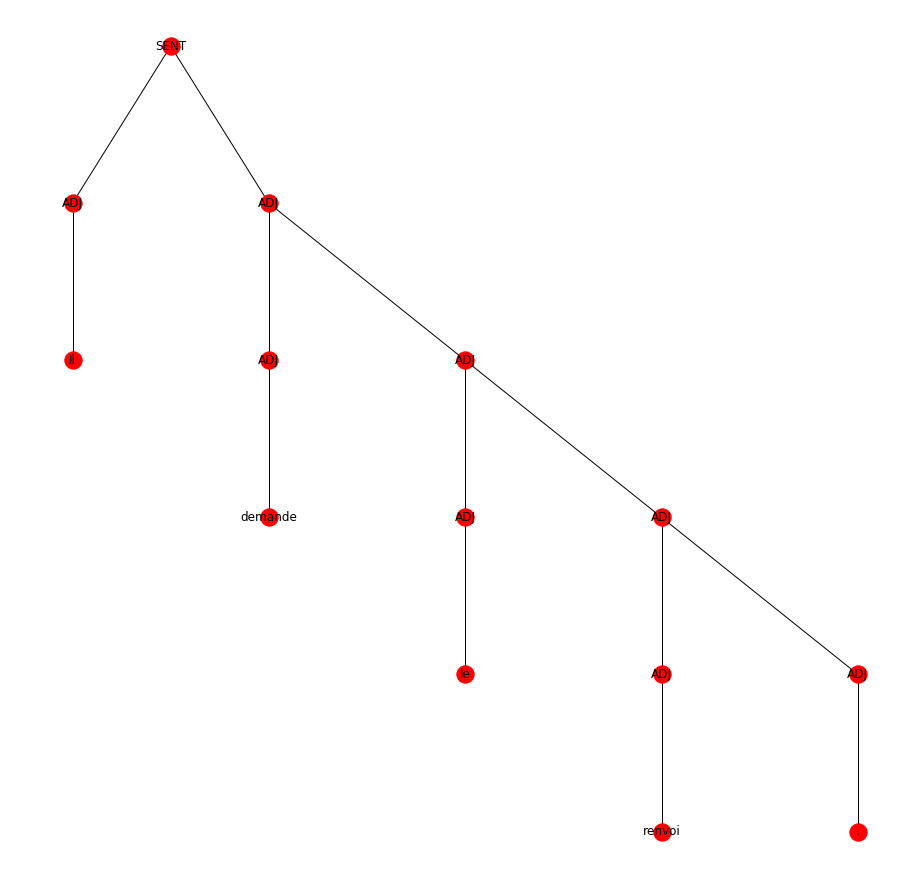

In [12]:
from utils_draw_tree import draw_tree
draw_tree(parsing)

In [11]:
print(set_all_symbols)
print(set_terminal_symbols)

['ADJ', 'ADJWH', 'ADV', 'ADVWH', 'AP', 'AdP', 'CC', 'CLO', 'CLR', 'CLS', 'COORD', 'CS', 'DET', 'DETWH', 'ET', 'I', 'NC', 'NP', 'NPP', 'P', 'P+D', 'P+PRO', 'PONCT', 'PP', 'PREF', 'PRO', 'PROREL', 'PROWH', 'SENT', 'Sint', 'Srel', 'Ssub', 'V', 'VIMP', 'VINF', 'VN', 'VPP', 'VPR', 'VPinf', 'VPpart', 'VS', 'NEW_0', 'NEW_1', 'NEW_2', 'NEW_3', 'NEW_4', 'NEW_5', 'NEW_6', 'NEW_7', 'NEW_8', 'NEW_9', 'NEW_10', 'NEW_11', 'NEW_12', 'NEW_13', 'NEW_14', 'NEW_15', 'NEW_16', 'NEW_17', 'NEW_18', 'NEW_19', 'NEW_20', 'NEW_21', 'NEW_22', 'NEW_23', 'NEW_24', 'NEW_25', 'NEW_26', 'NEW_27', 'NEW_28', 'NEW_29', 'NEW_30', 'NEW_31', 'NEW_32', 'NEW_33', 'NEW_34', 'NEW_35', 'NEW_36', 'NEW_37', 'NEW_38', 'NEW_39', 'NEW_40', 'NEW_41', 'NEW_42', 'NEW_43', 'NEW_44', 'NEW_45', 'NEW_46', 'NEW_47', 'NEW_48', 'NEW_49', 'NEW_50', 'NEW_51', 'NEW_52', 'NEW_53', 'NEW_54', 'NEW_55', 'NEW_56', 'NEW_57', 'NEW_58', 'NEW_59', 'NEW_60', 'NEW_61', 'NEW_62', 'NEW_63', 'NEW_64', 'NEW_65', 'NEW_66', 'NEW_67', 'NEW_68', 'NEW_69', 'NEW_70'